<a href="https://colab.research.google.com/github/MLP-deepdreamteam/Practice_captioning/blob/branch_%EB%B0%B1%EC%9A%B4%EC%B2%A0/image_caption_generation_on_coco_dataset_load_and_save.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

> Image captioning is the task of generating textual descriptions of a given image, requiring  techniques of computer vision and natural language processing.

It is a popular research area of Artificial Intelligence that deals with image understanding and a language description for that image. Generating well-formed sentences requires both syntactic and semantic understanding of the language. Being able to describe the content of an image using accurately formed sentences is a very challenging task, but it could also have a great impact, by helping visually impaired people better understand the content of images.  [source](https://www.analyticsvidhya.com/blog/2020/11/create-your-own-image-caption-generator-using-keras/) 

Here, I have used [COCO Dataset 2017](https://cocodataset.org/#download) which contains **12 different types of categories** and among them it has **80 types of sub-categories**. Each sub categories contain list of images and five captions to each image.

In [2]:
 !pip install pycocotools

from pycocotools.coco import COCO # COCO python library
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

import random
import string

import cv2
import os
from pickle import dump, load
import json

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

from keras.layers import add

from tensorflow.keras.models import Model, load_model

# small library for seeing the progress of loops.
from tqdm.notebook import tqdm

pylab.rcParams['figure.figsize'] = (8.0, 10.0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Exploring COCO Dataset

#### Initialize COCO class and operate instances_train2017.json

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
coco=COCO("/content/drive/MyDrive/coco_dataset/coco_ann2017/annotations/instances_train2017.json")

loading annotations into memory...
Done (t=35.87s)
creating index...
index created!


In [5]:
#### Find Categories

In [6]:
cats = coco.loadCats(coco.getCatIds())
maincategories = list(set([cat['supercategory'] for cat in cats]))

print("Number of main categories: ", len(maincategories))
print("List of main categories: ", maincategories)

Number of main categories:  12
List of main categories:  ['vehicle', 'accessory', 'person', 'animal', 'electronic', 'sports', 'kitchen', 'food', 'appliance', 'outdoor', 'furniture', 'indoor']


#### Find Sub Categories

In [7]:
subcategories = [cat['name'] for cat in cats]

print("Number of sub categories: ", len(subcategories))
print("List of sub categories: ", subcategories)

Number of sub categories:  80
List of sub categories:  ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


#### Find Sub categories with its corresponding IDs

In [8]:
catIds = coco.getCatIds(catNms=subcategories)

subcategories_Ids = dict()
for i in range(0,len(subcategories)):
    subcategories_Ids[subcategories[i]] = catIds[i]

print("Sub categories with IDs :",subcategories_Ids)

Sub categories with IDs : {'person': 1, 'bicycle': 2, 'car': 3, 'motorcycle': 4, 'airplane': 5, 'bus': 6, 'train': 7, 'truck': 8, 'boat': 9, 'traffic light': 10, 'fire hydrant': 11, 'stop sign': 13, 'parking meter': 14, 'bench': 15, 'bird': 16, 'cat': 17, 'dog': 18, 'horse': 19, 'sheep': 20, 'cow': 21, 'elephant': 22, 'bear': 23, 'zebra': 24, 'giraffe': 25, 'backpack': 27, 'umbrella': 28, 'handbag': 31, 'tie': 32, 'suitcase': 33, 'frisbee': 34, 'skis': 35, 'snowboard': 36, 'sports ball': 37, 'kite': 38, 'baseball bat': 39, 'baseball glove': 40, 'skateboard': 41, 'surfboard': 42, 'tennis racket': 43, 'bottle': 44, 'wine glass': 46, 'cup': 47, 'fork': 48, 'knife': 49, 'spoon': 50, 'bowl': 51, 'banana': 52, 'apple': 53, 'sandwich': 54, 'orange': 55, 'broccoli': 56, 'carrot': 57, 'hot dog': 58, 'pizza': 59, 'donut': 60, 'cake': 61, 'chair': 62, 'couch': 63, 'potted plant': 64, 'bed': 65, 'dining table': 67, 'toilet': 70, 'tv': 72, 'laptop': 73, 'mouse': 74, 'remote': 75, 'keyboard': 76, 'c

#### Find total images with each sub categories

In [9]:
subcategories_imageIds = dict()

for i in range(0,len(catIds)):
    imgIds = coco.getImgIds(catIds=catIds[i])
    img = []
    for j in imgIds: 
        img.append(j)
    subcategories_imageIds[subcategories[i]] = img
    
print("Sub categories with Image IDs :",len(subcategories_imageIds))

Sub categories with Image IDs : 80


In [10]:
length_dict = {key: len(value) for key, value in subcategories_imageIds.items()}
print("Total images in each sub categories: ", length_dict)

Total images in each sub categories:  {'person': 64115, 'bicycle': 3252, 'car': 12251, 'motorcycle': 3502, 'airplane': 2986, 'bus': 3952, 'train': 3588, 'truck': 6127, 'boat': 3025, 'traffic light': 4139, 'fire hydrant': 1711, 'stop sign': 1734, 'parking meter': 705, 'bench': 5570, 'bird': 3237, 'cat': 4114, 'dog': 4385, 'horse': 2941, 'sheep': 1529, 'cow': 1968, 'elephant': 2143, 'bear': 960, 'zebra': 1916, 'giraffe': 2546, 'backpack': 5528, 'umbrella': 3968, 'handbag': 6841, 'tie': 3810, 'suitcase': 2402, 'frisbee': 2184, 'skis': 3082, 'snowboard': 1654, 'sports ball': 4262, 'kite': 2261, 'baseball bat': 2506, 'baseball glove': 2629, 'skateboard': 3476, 'surfboard': 3486, 'tennis racket': 3394, 'bottle': 8501, 'wine glass': 2533, 'cup': 9189, 'fork': 3555, 'knife': 4326, 'spoon': 3529, 'bowl': 7111, 'banana': 2243, 'apple': 1586, 'sandwich': 2365, 'orange': 1699, 'broccoli': 1939, 'carrot': 1683, 'hot dog': 1222, 'pizza': 3166, 'donut': 1523, 'cake': 2925, 'chair': 12774, 'couch': 44

In [11]:
#subcategories_imageIds['bicycle']

Here, I have selected two sub categories **Bicycle** and **Airplane** for accomplishing image caption generator project.

In [12]:
# Define the classes (out of the 81) which you want to see. Others will not be shown.
filterClasses = ['person', 'skateboard']
filterClasses2 = ['person', 'sports ball']
filterClasses3 = ['person', 'dog']

# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms=filterClasses)
catIds2 = coco.getCatIds(catNms=filterClasses2)
catIds3 = coco.getCatIds(catNms=filterClasses3)
# Get all images containing the above Category IDs
imgIdss = coco.getImgIds(catIds=catIds) + coco.getImgIds(catIds=catIds2) +coco.getImgIds(catIds=catIds3)
print("Number of images containing all the  classes:", len(imgIdss))


# train_cats = subcategories_imageIds['person, sports ball'] + subcategories_imageIds['person' , 'skateboard' ]
# imgIdss = coco.getImgIds(imgIds = train_cats)
# print("Total Images: ", len(imgIdss))

Number of images containing all the  classes: 9563


#### Load some of the random images

In [13]:
import random
random.shuffle(imgIdss)


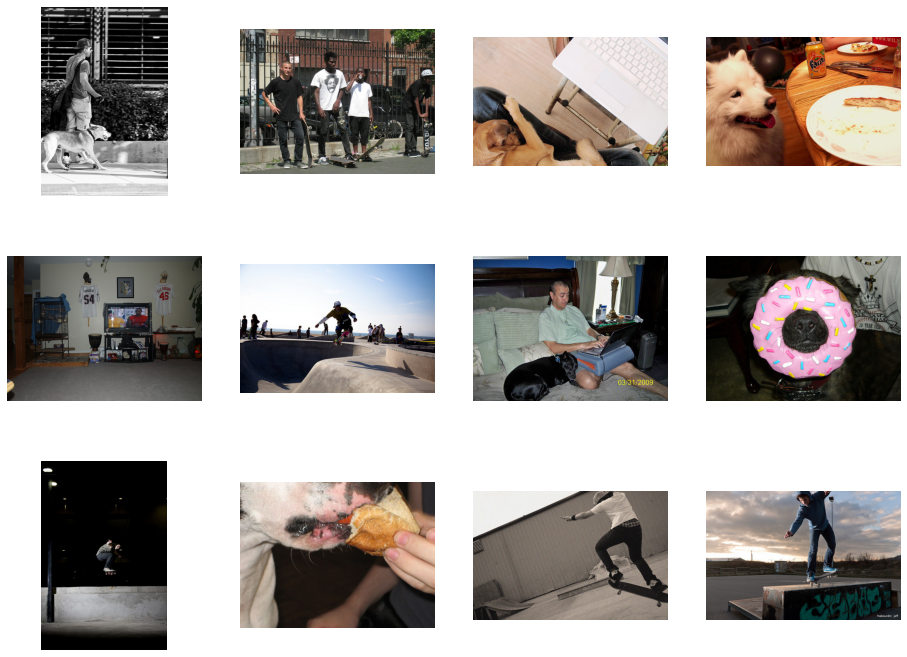

In [14]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

next_pix = imgIdss
random.shuffle(next_pix)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)

plt.show()

#### Load some of the random images with segmented objects inside them 

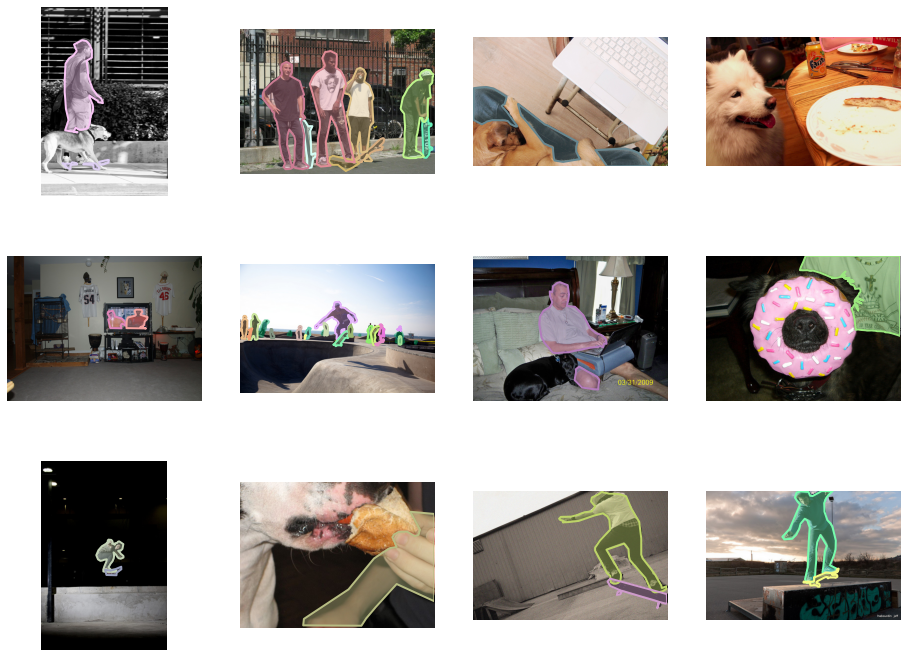

In [15]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    # print(anns)
    coco.showAnns(anns)
    

plt.show()

#### Load images with keypoints objects

In [16]:
annFile = "/content/drive/MyDrive/coco_dataset/coco_ann2017/annotations/person_keypoints_train2017.json"
coco_kps=COCO(annFile)

loading annotations into memory...
Done (t=9.77s)
creating index...
index created!


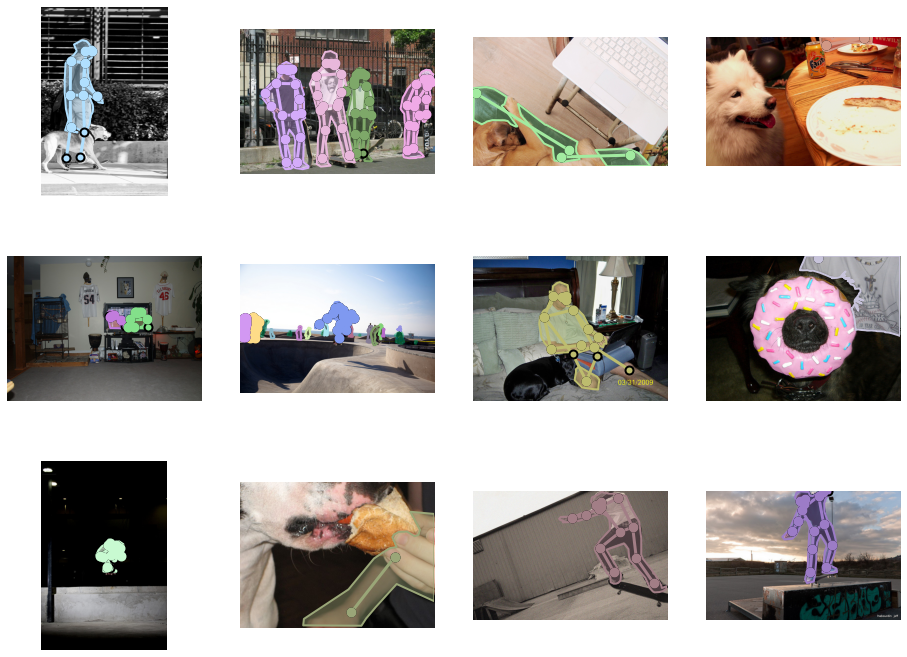

In [17]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)
    annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco_kps.loadAnns(annIds)
    coco_kps.showAnns(anns)
    

plt.show()

#### Load images with respective captions

In [18]:
annFile = "/content/drive/MyDrive/coco_dataset/coco_ann2017/annotations/captions_train2017.json"
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=1.73s)
creating index...
index created!


A man walking a dog on the side walk.
A person on a skateboard walking a dog.
A dog walking next to a man riding a skateboard.
A man carrying a satchel rides a skateboard alongside his dog.
A black and white candid of a man on his skateboard walking his dog.


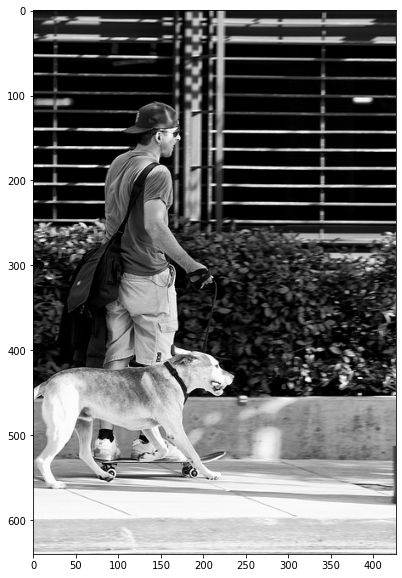

In [19]:
img = coco.loadImgs(next_pix[0])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

A group of young men standing on a sidewalk in front of a building.
A group of young men with skateboards by a fence.
Four young men with their skateboards stand next to an iron fence.
Four boys with skateboard relax by an iron fence.
A group of young adult males standing with their skateboards


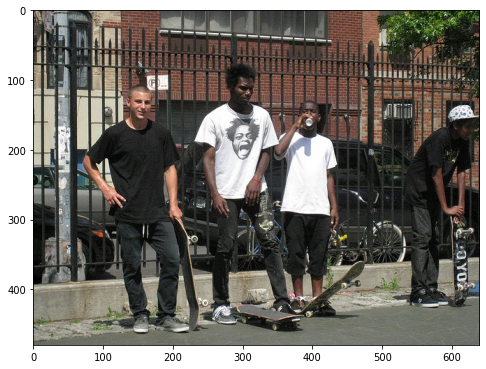

In [20]:
img = coco.loadImgs(next_pix[1])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

Black and white photograph of a skate boarder climbing his board
The man is riding his skateboard in the parking lot. 
A man with a skateboard is flipping and jumping.
SKATEBOARDER WITH HIS BOXERS HANGING OUT OF HIS PANTS.
Man in jeans and white shirt jumping on top of a black board. 


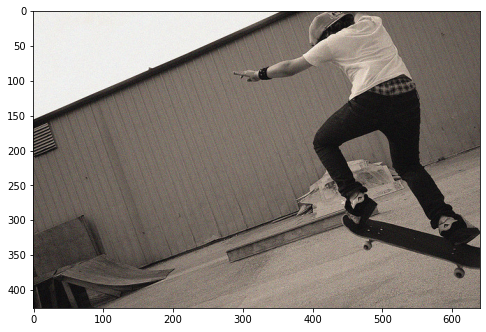

In [21]:
img = coco.loadImgs(next_pix[10])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

# Image caption generator
#### Here I have taken "Bicycle" and "Airplane" images and captions only.


In [22]:
print("Total images for training: ", len(imgIdss))

Total images for training:  9563


# Prepare Dataset 

#### Group all captions together having the same image and store them in dict.

In [23]:
dataset = dict()
imgcaptions = []

for imgid in imgIdss:
    img = coco.loadImgs(imgid)[0]
    annIds = coco_caps.getAnnIds(imgIds=img['id']);
    anns = coco_caps.loadAnns(annIds)
    imgcaptions = []
    for cap in anns:
        
        # Remove punctuation
        cap = cap['caption'].translate(str.maketrans('', '', string.punctuation))
        
        # Replace - to blank
        cap = cap.replace("-"," ")
        
        # Split string into word list and Convert each word into lower case
        cap = cap.split()
        cap = [word.lower() for word in cap]
        
        # join word list into sentence and <start> and <end> tag to each sentence which helps 
        # LSTM encoder-decoder model while training.
        
        cap = '<start> ' + " ".join(cap) + ' <end>'
        imgcaptions.append(cap)
        
    dataset[img['coco_url']] = imgcaptions 
    
print("Length of Dataset: ",len(dataset))
# print(dataset['http://images.cocodataset.org/train2017/000000047084.jpg'])
#dataset

print("type of Dataset: " ,type(dataset))



Length of Dataset:  9446
type of Dataset:  <class 'dict'>


In [24]:
import itertools

testsample_dict= dict(itertools.islice(dataset.items(), 100))





# Preprocess and tokenize the captions

In [27]:
from itertools import chain
tokenizer = []
def tokenize_mycaption(dataset):
  global tokenizer
  flatten_list = list(chain.from_iterable(dataset.values())) #[[1,3],[4,8]] = [1,3,4,8]

  tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
  tokenizer.fit_on_texts(flatten_list)
  total_words = len(tokenizer.word_index) + 1

  print("Vocabulary length: ", total_words)
  print("Bicycle ID: ", tokenizer.word_index['bicycle'])
  # print("Airplane ID: ", tokenizer.word_index['airplane'])


In [28]:

import csv
with open('/content/drive/MyDrive/3조/donut_token', 'r') as f:
    csv_reader = csv.reader(f)
    for line in csv_reader:
     flatten_list =  line

with open('/content/drive/MyDrive/3조/dataset', 'r') as f2:
    csv_reader = csv.reader(f2)
    for line in csv_reader:
     dataset =  dataset


tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(flatten_list)
total_words = len(tokenizer.word_index) + 1

print("Vocabulary length: ", total_words)
print("Bicycle ID: ", tokenizer.word_index['bicycle'])
# print("Airplane ID: ", tokenizer.word_index['airplane'])



Vocabulary length:  2968
Bicycle ID:  704


In [29]:
tokenize_mycaption(testsample_dict)
print(total_words)
print(tokenizer.word_index)


Vocabulary length:  675
Bicycle ID:  417
2968
{'<oov>': 1, 'a': 2, 'end': 3, 'start': 4, 'on': 5, 'the': 6, 'man': 7, 'in': 8, 'tennis': 9, 'of': 10, 'skateboard': 11, 'is': 12, 'with': 13, 'dog': 14, 'and': 15, 'to': 16, 'ball': 17, 'his': 18, 'baseball': 19, 'player': 20, 'at': 21, 'skateboarder': 22, 'young': 23, 'woman': 24, 'person': 25, 'skate': 26, 'air': 27, 'riding': 28, 'playing': 29, 'trick': 30, 'court': 31, 'standing': 32, 'while': 33, 'two': 34, 'doing': 35, 'field': 36, 'racket': 37, 'people': 38, 'park': 39, 'board': 40, 'holding': 41, 'white': 42, 'boy': 43, 'jumping': 44, 'black': 45, 'are': 46, 'next': 47, 'that': 48, 'hit': 49, 'an': 50, 'sitting': 51, 'game': 52, 'as': 53, 'hitting': 54, 'front': 55, 'wall': 56, 'down': 57, 'girl': 58, 'ramp': 59, 'bench': 60, 'group': 61, 'by': 62, 'near': 63, 'up': 64, 'swinging': 65, 'skateboards': 66, 'over': 67, 'tricks': 68, 'top': 69, 'blue': 70, 'racquet': 71, 'bat': 72, 'picture': 73, 'performing': 74, 'male': 75, 'skatebo

# Preprocess and caching the features extracted from InceptionV3

I will use InceptionV3 (which is pretrained on Imagenet) to classify each image. I will extract features from the last convolutional layer. This is also called a tranfer learning.

Since the Xception model was originally built for **imagenet**, we will do little changes for integrating with our model. Here, the Xception model takes **100 x 100 x 3** image size as input. We will remove the last classification layer and get the **2048 feature vector**.

In [ ]:
# def CNN_Encoder(): # Inception
#     inception_v3 = tf.keras.applications.InceptionV3(
#         include_top=False,
#         weights='imagenet'
#     )

#     output = inception_v3.output
#     print("output1\n", output,"\n------------------------------------------------------------")
#     # inception_v3.output , 즉    (None, 2048) 

#     output = tf.keras.layers.Reshape(
#         (-1, output.shape[-1]))(output)
#     # output after reshape

#     print("output2\n", output,"\n------------------------------------------------------------")

#     cnn_model = tf.keras.models.Model(inception_v3.input, output)
#     return cnn_model

In [78]:
model = Xception(include_top=False, pooling='avg',  weights='imagenet')

image_features = {}


# dataset.keys()
for img in tqdm(testsample_dict.keys()):
    image = io.imread(img)
    if image.ndim != 3:
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    
    # Resize each image size 299 x 299
    image = cv2.resize(image,(299,299))
    image = np.expand_dims(image, axis=0)
    
    # Normalize image pixels
    image = image/127.5
    image = image - 1.0

    # Extract features from image
    feature = model.predict(image)
    image_features[img] = feature
    
print("Image features length: ", len(image_features))

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step
Image features length:  100


Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_10[0][0]']               
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                        

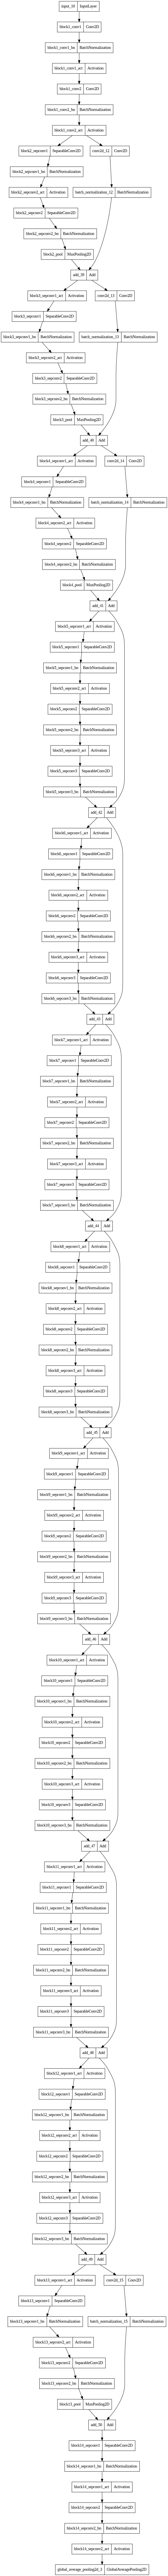

In [79]:

from keras.utils import plot_model

model.summary()

plot_model(model, to_file='model.png')


Here, I have found the max_length among the captions which will help to pad each caption with the same length.

In [32]:
testsample_dict


def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(dataset)
max_length

51

# Make a Data Generator

We have to train our model on 6221 images and each image will contain 2048 length feature vector and caption is also represented as numbers. This amount of data for 6221 images is not possible to hold into memory so we will be using a generator method that will yield batches.

**The generator will yield the input and output sequence.**

##### For example:

The input to our model is [x1, x2] and the output will be y, where x1 is the 2048 feature vector of that image, x2 is the input text sequence and y is the output text sequence that the model has to predict.

![Capture.PNG](attachment:abfdd0f4-ece1-4fe8-a9db-4060a31f10fd.PNG)

In [33]:
#create input-output sequence pairs from the image description.

def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():

            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)
            

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    
    # walk through each description for the image
    for desc in desc_list:
        
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=total_words)[0]
            
            # store
            X1.append(feature) # image features
            X2.append(in_seq)  # Caption input
            y.append(out_seq)  # Caption output
            
    return np.array(X1), np.array(X2), np.array(y)


# Define CNN-LSTM Model

#### CNN (Convolution Neural Network)

Technically, deep learning CNN models to train and test, each input image will pass it through a series of convolution layers with filters (Kernals), Pooling, fully connected layers (FC) and apply Softmax function to classify an object with probabilistic values between 0 and 1.


#### [Click here](https://www.analyticsvidhya.com/blog/2018/12/guide-convolutional-neural-network-cnn/) to know more about CNN.

<br>

#### LSTM (Long short-term memory)


Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems. This is a behavior required in complex problem domains like machine translation, speech recognition, and more. LSTMs are a complex area of deep learning


#### [Click here](https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/) to know more about LSTM.


# Model Architechture 

### CNN-LSTM model:

- CNN is used for extracting features from the image. We will use the pre-trained model Xception.
- LSTM will use the information from CNN to help generate a description of the image.


### Model structure

![model.png](attachment:5e082228-cfa2-49fe-9526-fd31a45a9868.png)


* The feature extracted from the image has a size of 2048, with a dense layer, we will reduce the dimensions to 256 nodes.<br> 
* An embedding layer will handle the text input,followed by the LSTM layer.
<br>
* Then By merging the output from the above two layers, we will process by the dense layer to make the final prediction. The final layer will contain the number of nodes equal to our vocabulary size.

In [34]:
from tensorflow.keras.utils import plot_model

# define the captioning model
def define_model(total_words, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(total_words, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(total_words, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model


In [48]:
# train our model
import os

# os.mkdir(models)

# testsample_dict
model = define_model(total_words, max_length)

def train_our_model(dataset):


  print('Dataset: ', len(dataset))
  print('Descriptions: train=', len(dataset))
  print('Photos: train=', len(image_features))
  print('Vocabulary Size:', total_words)
  print('Description Length: ', max_length)

  epochs=1
  steps = len(dataset)

  # making a directory models to save our models

  
  for i in range(epochs):
      generator = data_generator(dataset, image_features, tokenizer, max_length)
      model.fit(generator, epochs=5, steps_per_epoch= steps, verbose=1)
      model.save("models/model_" + str(i) + ".h5")

train_our_model(testsample_dict)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 51, 256)      759808      ['input_8[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 2048)         0           ['input_7[0][0]']                
                                                                                            

In [49]:
model.name

'model_2'

In [50]:
model.save("models/model_0.h5")

In [51]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob
img_paths = []
for filename in glob.glob('./drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/*.jpg'): #assuming jpg
    # im=Image.open(filename)
    # print(filename)
    # print(im)
    img_paths.append(filename)

    if len(img_paths)>10:
      break
print(img_paths)


['./drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000571635.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000202658.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000203564.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000410627.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000208408.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000581177.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000153184.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000027842.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_tr

In [52]:

def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        
        if word is None:
            break
        in_text += ' ' + word
        
        if word == 'end':
            break
    return in_text


    


In [53]:

#max_length = 46

xception_model = Xception(include_top=False, pooling="avg")

# folder_dir = "../input/personskateboard"
# for image_url in os.listdir(folder_dir):
#     image_path = image_url
#     #image_path = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQKb5CzpOLqj3aVhUiP5NT4pJhd32WdQTsA5A&usqp=CAU"
#     print(image_path)
#     image_path = os.path.join("../input/personskateboard/", image_path)
#     photo = extract_features(image_path, xception_model)
#     img = Image.open(image_path)
#     description = generate_desc(model, tokenizer, photo, max_length)
#     print("\n\n")
#     print(description)
#     plt.imshow(img)




42
model_2


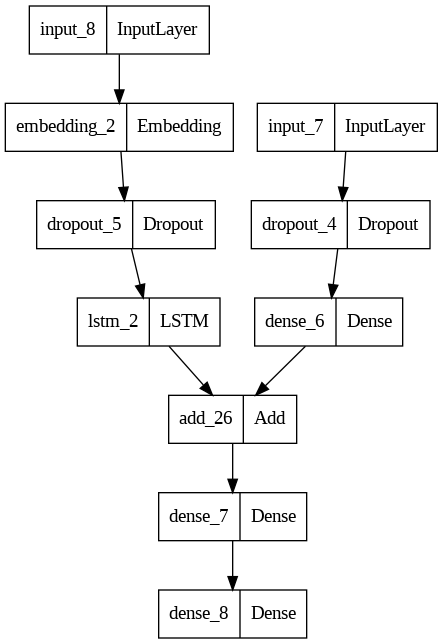

In [69]:
print(max_length)
print(model.name)

from keras.utils import plot_model
plot_model(model, to_file='model.png')


1/1 [==============================] - 1s 1s/step



start a man is on a skateboard on a skateboard end


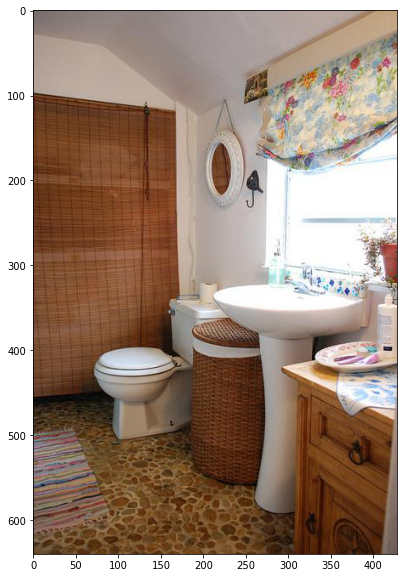

In [55]:
photo = extract_features(img_paths[0], xception_model)
img = Image.open(img_paths[0])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 42)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 42, 256)      759808      ['input_4[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_3[0][0]']                
                                                                                            

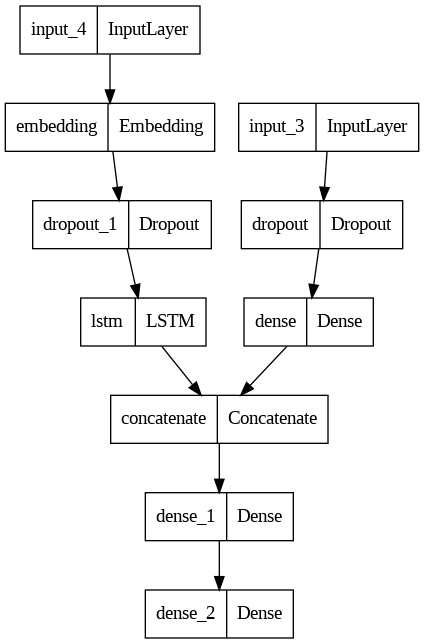

In [70]:
copy_model2 = load_model('./drive/MyDrive/3조/best_model.h5')
copy_ssd = load_model('/content/drive/MyDrive/3조/ssd300.h5')

copy_model2.summary()
copy_ssd.summary()




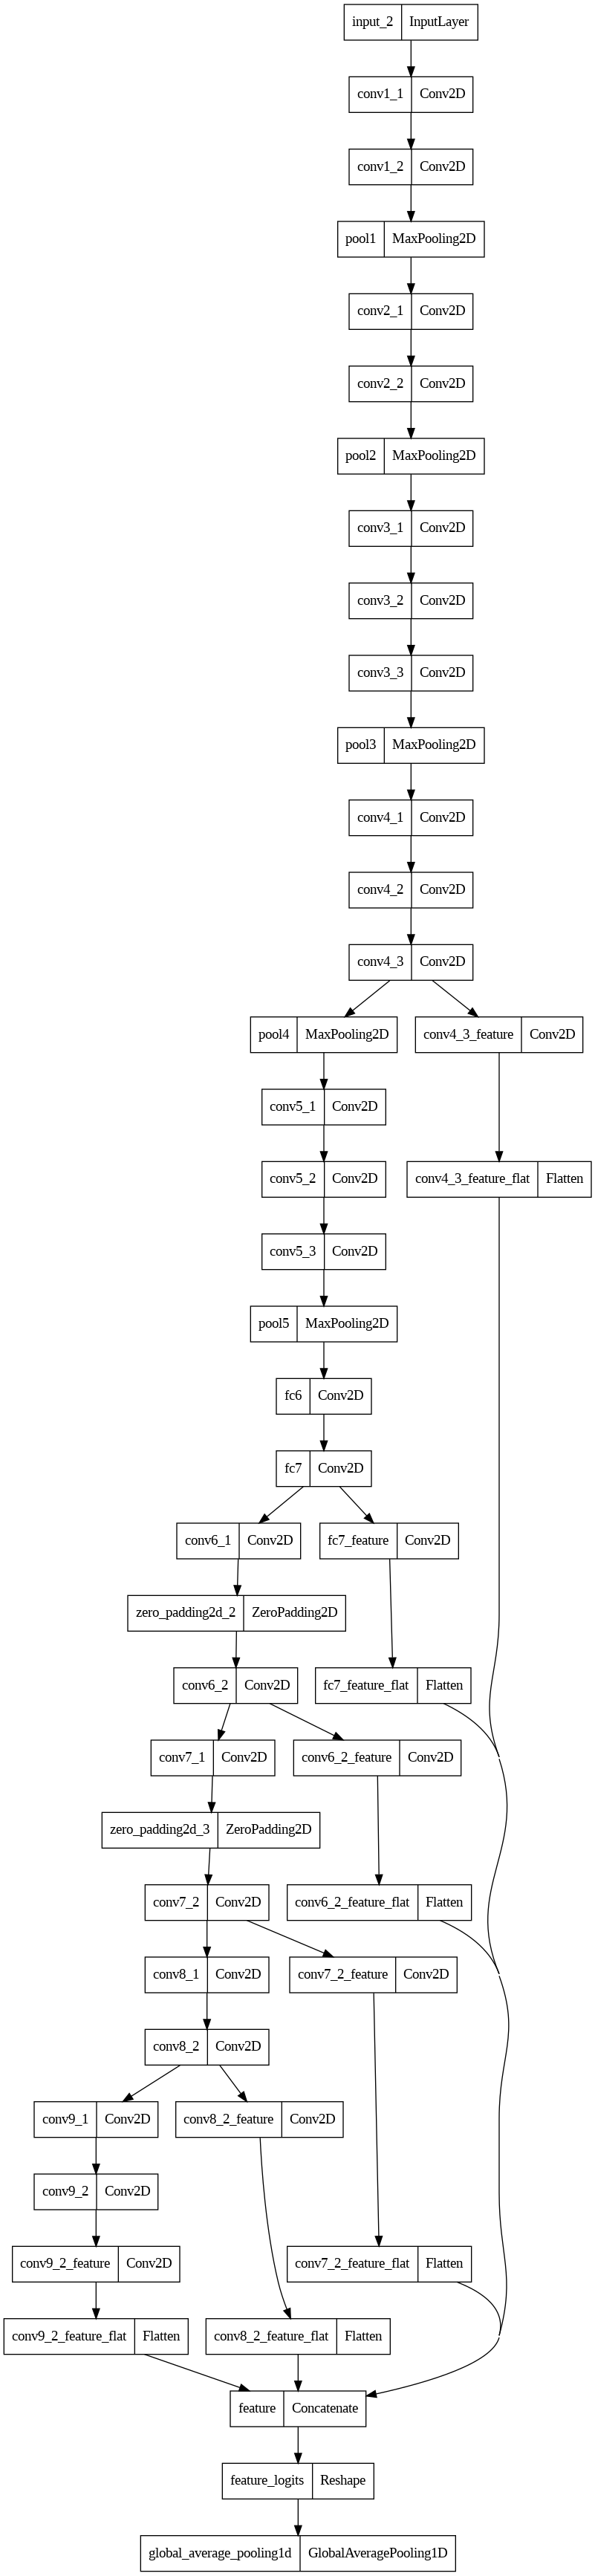

In [75]:
plot_model(copy_ssd, to_file='model0.png')


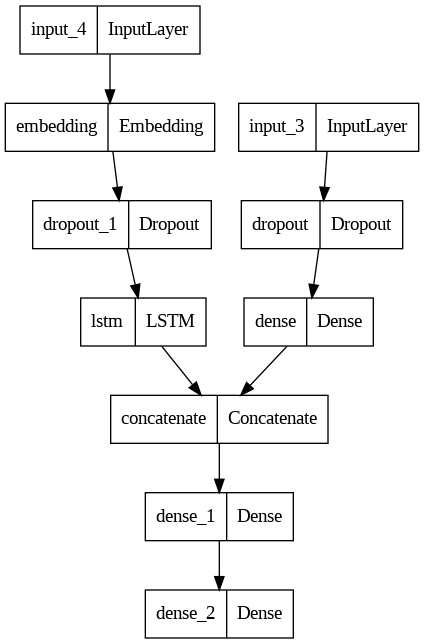

In [76]:
plot_model(copy_model2, to_file='model1.png')


In [58]:
max_length =42
generator = data_generator(dataset, image_features, tokenizer, max_length)


In [59]:
max_length =42

1/1 [==============================] - 0s 23ms/step



start a his with player a and the hit end


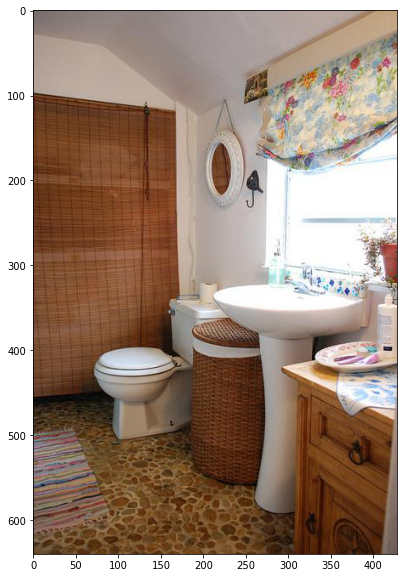

In [65]:

photo = extract_features(img_paths[0], copy_ssd)
img = Image.open(img_paths[0])
description = generate_desc(copy_model2, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 0s 35ms/step



start a his with player a and the hit end


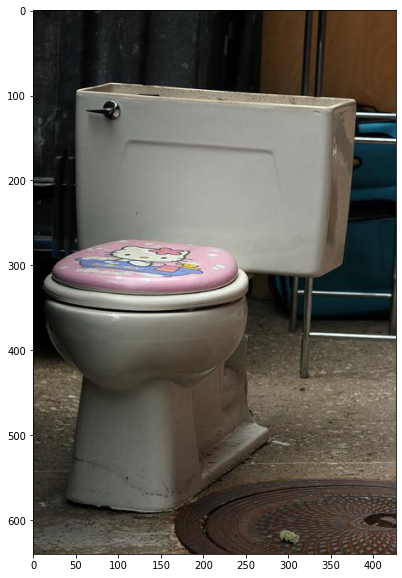

In [66]:

photo = extract_features(img_paths[1], copy_ssd)
img = Image.open(img_paths[1])
description = generate_desc(copy_model2, tokenizer, photo, 42)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 0s 37ms/step



start a man is on a skateboard on a skateboard end


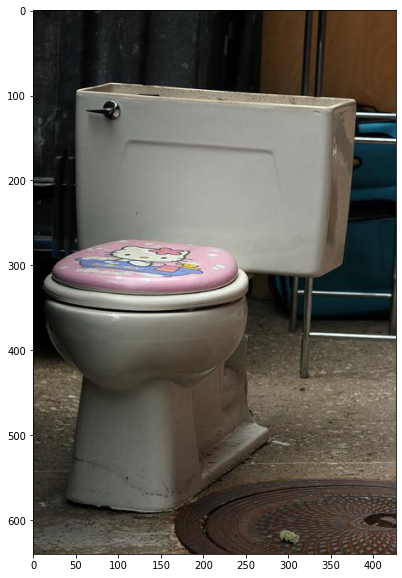

In [67]:
photo = extract_features(img_paths[1], xception_model)
img = Image.open(img_paths[1])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 0s 27ms/step



start a man is a skateboard on a skateboard end


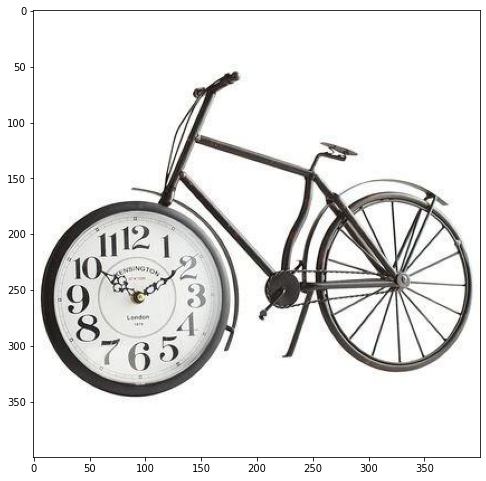

In [68]:
photo = extract_features(img_paths[2], xception_model)
img = Image.open(img_paths[2])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 0s 23ms/step



start a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


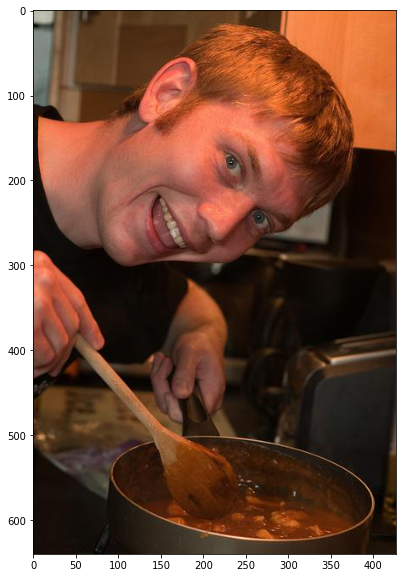

In [ ]:
photo = extract_features(img_paths[3], xception_model)
img = Image.open(img_paths[3])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 0s 36ms/step



start a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


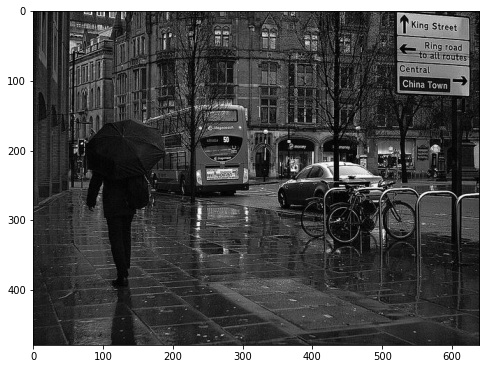

In [ ]:
photo = extract_features(img_paths[4], xception_model)
img = Image.open(img_paths[4])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 0s 24ms/step



start a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


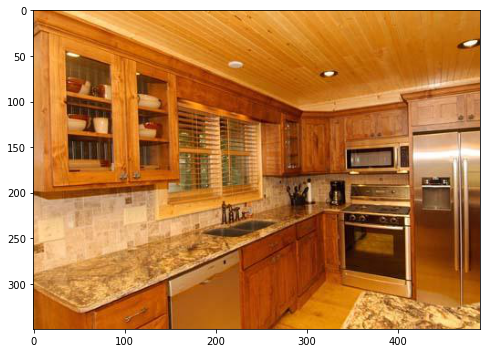

In [ ]:
photo = extract_features(img_paths[5], xception_model)
img = Image.open(img_paths[5])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 0s 26ms/step



start a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


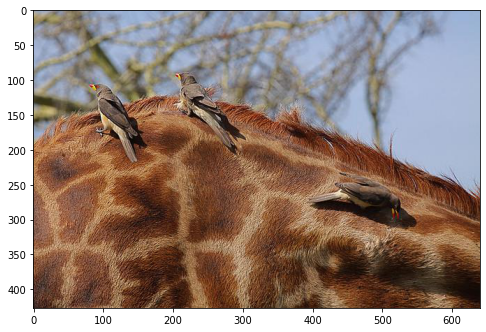

In [ ]:
photo = extract_features(img_paths[6], xception_model)
img = Image.open(img_paths[6])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 0s 24ms/step



start a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


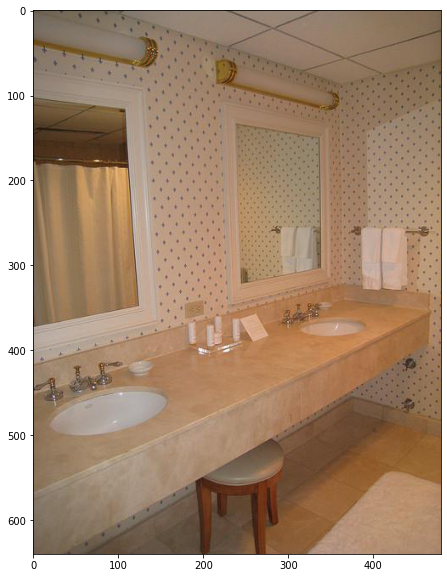

In [ ]:
photo = extract_features(img_paths[7], xception_model)
img = Image.open(img_paths[7])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 0s 27ms/step



start a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


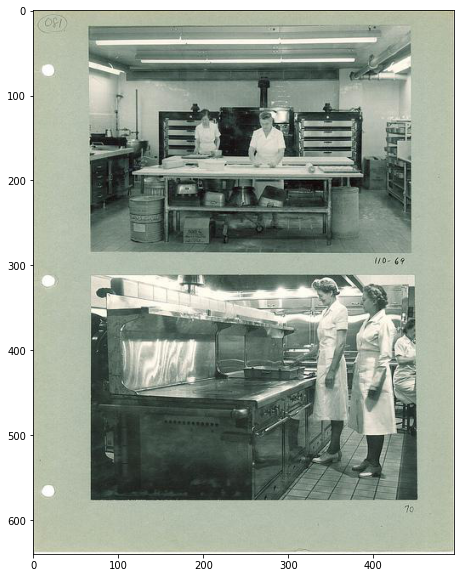

In [ ]:
photo = extract_features(img_paths[8], xception_model)
img = Image.open(img_paths[8])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

1/1 [==============================] - 0s 42ms/step



start a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


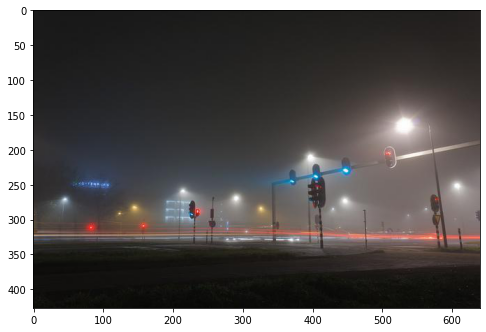

In [ ]:
photo = extract_features(img_paths[9], xception_model)
img = Image.open(img_paths[9])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt




img_paths = ["../input/PersonDog/152209389_9891c4a659_z.jpg",
            "../input/PersonDog/3116460759_4366991e50_z.jpg",
            "../input/PersonDog/3714191463_137a6830d2_z.jpg",
            "../input/PersonDog/4769871455_b4065f4049_z.jpg",
            "../input/PersonDog/5041694361_26ba1432d9_z.jpg",
            "../input/PersonDog/5180932847_a1fc8bd754_z.jpg",
            "../input/PersonDog/5287986212_0a37236921_z.jpg",
            "../input/PersonDog/7650012928_2d5a854761_z.jpg",
            "../input/PersonDog/8137600617_7f609c5c58_z.jpg",
            "../input/PersonDog/9309616799_765810568c_z.jpg"]

def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        
        if word is None:
            break
        in_text += ' ' + word
        
        if word == 'end':
            break
    return in_text


#max_length = 46

model = load_model('./models/model_0.h5')
xception_model = Xception(include_top=False, pooling="avg")

# folder_dir = "../input/personskateboard"
# for image_url in os.listdir(folder_dir):
#     image_path = image_url
#     #image_path = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQKb5CzpOLqj3aVhUiP5NT4pJhd32WdQTsA5A&usqp=CAU"
#     print(image_path)
#     image_path = os.path.join("../input/personskateboard/", image_path)
#     photo = extract_features(image_path, xception_model)
#     img = Image.open(image_path)
#     description = generate_desc(model, tokenizer, photo, max_length)
#     print("\n\n")
#     print(description)
#     plt.imshow(img)


photo = extract_features(img_paths[0], xception_model)
img = Image.open(img_paths[0])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)
    


ERROR: Couldn't open image! Make sure the image path and extension is correct


UnboundLocalError: ignored

In [ ]:
photo = extract_features(img_paths[1], xception_model)
img = Image.open(img_paths[1])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
photo = extract_features(img_paths[2], xception_model)
img = Image.open(img_paths[2])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
photo = extract_features(img_paths[3], xception_model)
img = Image.open(img_paths[3])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
photo = extract_features(img_paths[4], xception_model)
img = Image.open(img_paths[4])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
photo = extract_features(img_paths[5], xception_model)
img = Image.open(img_paths[5])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
photo = extract_features(img_paths[6], xception_model)
img = Image.open(img_paths[6])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
photo = extract_features(img_paths[7], xception_model)
img = Image.open(img_paths[7])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
photo = extract_features(img_paths[8], xception_model)
img = Image.open(img_paths[8])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
photo = extract_features(img_paths[9], xception_model)
img = Image.open(img_paths[9])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt




img_paths = ["../input/PersonSkateboard/154327766_38ef02988e_z.jpg",
            "../input/PersonSkateboard/1572160007_8aa3c604fb_z.jpg",
            "../input/PersonSkateboard/2834929728_4afaa79070_z.jpg",
            "../input/PersonSkateboard/2887442654_1f10d1282e_z.jpg",
            "../input/PersonSkateboard/3163848727_031222e46e_z.jpg",
            "../input/PersonSkateboard/3924443051_cc2826ce43_z.jpg",
            "../input/PersonSkateboard/412139096_ceabda5824_z.jpg",
            "../input/PersonSkateboard/4813912632_3c58998108_z.jpg",
            "../input/PersonSkateboard/6073819312_15e220a879_z.jpg",
            "../input/PersonSkateboard/8545457214_05245df366_z.jpg"]

def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        
        if word is None:
            break
        in_text += ' ' + word
        
        if word == 'end':
            break
    return in_text


#max_length = 46

model = load_model('./models/model_0.h5')
xception_model = Xception(include_top=False, pooling="avg")

# folder_dir = "../input/personskateboard"
# for image_url in os.listdir(folder_dir):
#     image_path = image_url
#     #image_path = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQKb5CzpOLqj3aVhUiP5NT4pJhd32WdQTsA5A&usqp=CAU"
#     print(image_path)
#     image_path = os.path.join("../input/personskateboard/", image_path)
#     photo = extract_features(image_path, xception_model)
#     img = Image.open(image_path)
#     description = generate_desc(model, tokenizer, photo, max_length)
#     print("\n\n")
#     print(description)
#     plt.imshow(img)


photo = extract_features(img_paths[0], xception_model)
img = Image.open(img_paths[0])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)
    


In [ ]:
photo = extract_features(img_paths[1], xception_model)
img = Image.open(img_paths[1])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
photo = extract_features(img_paths[2], xception_model)
img = Image.open(img_paths[2])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
photo = extract_features(img_paths[3], xception_model)
img = Image.open(img_paths[3])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
photo = extract_features(img_paths[4], xception_model)
img = Image.open(img_paths[4])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
photo = extract_features(img_paths[5], xception_model)
img = Image.open(img_paths[5])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
photo = extract_features(img_paths[6], xception_model)
img = Image.open(img_paths[6])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
photo = extract_features(img_paths[7], xception_model)
img = Image.open(img_paths[7])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
photo = extract_features(img_paths[8], xception_model)
img = Image.open(img_paths[8])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
photo = extract_features(img_paths[9], xception_model)
img = Image.open(img_paths[9])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

References :
- https://www.analyticsvidhya.com/blog/2020/11/create-your-own-image-caption-generator-using-keras/
- https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb
- https://www.tensorflow.org/tutorials/text/image_captioning
- https://data-flair.training/blogs/python-based-project-image-caption-generator-cnn/